In [21]:
import numpy as np
import pandas as pd
import torch
import cv2
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import matplotlib.pyplot as plt
from torch.nn import TripletMarginLoss
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [22]:
import cv2
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

def detect_and_crop_face(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        return image
    (x, y, w, h) = max(faces, key=lambda face: face[2] * face[3])
    cropped_face = image.crop((x, y, x + w, y + h))
    return cropped_face

mean = [0.5]
std = [0.5]

train_transform = transforms.Compose([
    transforms.Lambda(lambda img: detect_and_crop_face(img)),
    transforms.Resize((224, 224)),            
    transforms.RandomHorizontalFlip(),       
    transforms.RandomRotation(10),           
    transforms.ToTensor(),                 
    transforms.Normalize(mean=mean, std=std)  
])

data_dataset = datasets.ImageFolder(root='./data/train/', transform=train_transform)
batch_size = 1
data_loader = DataLoader(data_dataset, batch_size=batch_size, shuffle=False)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [24]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 5)
model.load_state_dict(torch.load('saved models/512x5-98-96.pth'))
model.to(device)
model.eval()

print("done")

done


In [25]:
cpu_tensor = model.fc.weight.cpu()  
numpy_array = cpu_tensor.detach().numpy()

cpu_bias = model.fc.bias.cpu() 
numpy_bias = cpu_bias.detach().numpy()

print(numpy_array.shape)
print(numpy_bias.shape)

reshaped_bias = numpy_bias.reshape(-1, 1)
print(reshaped_bias.shape)  

(5, 512)
(5,)
(5, 1)


In [26]:
features = {}

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [27]:
model.avgpool.register_forward_hook(get_features("feature-vector"))

In [77]:
import torch

PREDS = []
FEATS = []


for idx, inputs in enumerate(data_loader):
    with torch.no_grad(): 

        input_tensor = inputs[0]
    
        if not isinstance(input_tensor, torch.Tensor):
            raise TypeError("data_loader should yield tensors")

        input_tensor = input_tensor.to(device)

        preds = model(input_tensor)

        PREDS.append(preds.detach().cpu().numpy())

        if "feature-vector" in features:
            FEATS.append(features["feature-vector"].cpu().numpy())
        else:
            print(f"Warning: 'feature' key not found in features dictionary at index {idx}")


In [29]:
PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)

print("- preds shape:", PREDS.shape)
print("- feats shape:", FEATS.shape)

- preds shape: (93, 5)
- feats shape: (93, 512, 1, 1)


In [30]:
# print(FEATS[0][:][:][:].shape)
reshaped_feats = FEATS.reshape(-1, 512, 1)
print(reshaped_feats[0].T.shape)
print(numpy_array.T.shape)
print(reshaped_bias.T.shape)

(1, 512)
(512, 5)
(1, 5)


In [31]:
(reshaped_feats[0].T @ (numpy_array.T) + reshaped_bias.T  ) 

array([[ 5.0286183 , -3.6762073 , -0.85995394, -0.1291533 , -0.70784867]],
      dtype=float32)

In [32]:
PREDS

array([[ 5.0286183 , -3.6762078 , -0.8599538 , -0.12915328, -0.70784885],
       [ 5.5665803 , -3.3751674 , -1.139625  ,  0.4067464 , -1.7688739 ],
       [ 4.8859577 , -2.8394668 , -1.647493  ,  2.1505435 , -2.6532726 ],
       [ 7.896555  , -4.541286  , -1.5075024 , -0.305629  , -1.4872379 ],
       [ 4.6304636 , -4.2259116 , -2.4131577 , -0.9557992 ,  1.5172967 ],
       [ 3.4273224 , -3.9381907 , -1.3564067 ,  2.7974174 , -0.6509875 ],
       [ 8.791686  , -5.085083  , -0.79903394, -0.8403528 , -1.7905041 ],
       [ 6.9978256 , -4.69429   , -2.6557457 ,  1.314125  , -1.0692135 ],
       [ 6.0440536 , -2.4941478 , -0.75203717,  0.7401051 , -3.5208724 ],
       [ 7.51278   , -3.894084  , -3.1047018 , -0.3221139 , -0.42895254],
       [ 5.112399  , -1.5079699 , -2.262107  , -0.50307983, -1.5071329 ],
       [ 3.270721  , -2.1090252 , -2.270976  , -1.593239  ,  0.91561276],
       [ 8.806219  , -3.5278468 , -0.78875566, -2.0409017 , -2.6553195 ],
       [ 4.7923427 , -3.5986671 , -2.8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


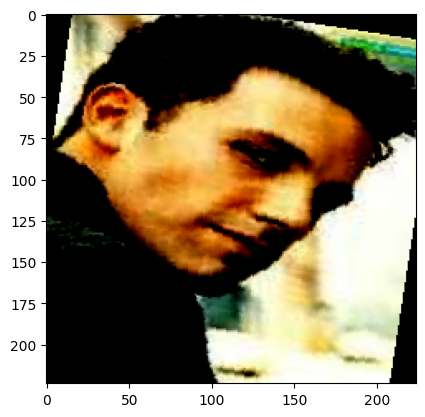

In [33]:
import matplotlib.pyplot as plt

dataiter = iter(data_loader)
images, labels = dataiter._next_data()

image = images[0].squeeze()  
image = image.numpy().transpose((1, 2, 0)) 

plt.imshow(image)
plt.show()

In [34]:
# if FEATS[0].shape[0] == 1:
# feature_map = FEATS[0].squeeze(0)  # Remove batch dimension if it's 1
# else:
#     feature_map = FEATS[0]  # Keep the feature maps as-is if batch size > 1

# print(feature_map.shape)
# Check if bias term matches the number of output channels
# if numpy_bias.shape[0] != feature_map.shape[-1]:
#     raise ValueError("Bias term shape doesn't match feature map channels")

# Perform efficient matrix multiplication with broadcasting
# result = np.einsum("ij,jk->ik", feature_map[0], numpy_array) + numpy_bias

# result.shape will depend on the shapes of feature_map and numpy_array
# print(result.shape)

In [73]:
import numpy as np
def IEEE_754(n):
    if n<0:
        return "1"+bin((int(np.float32(-n).view('int32'))))[2:].zfill(31)+" "
    return bin((int(np.float32(n).view('int32'))))[2:].zfill(32)+" "

print(IEEE_754(-0.5))

def convert_32_to_64_bit(data):
    prefix = "0110"

    groups = [data[i:i+4] for i in range(0, len(data)-1, 4)]

    result = prefix + prefix.join(groups)

    return result

def inverse_convert_32_to_64_bit(data):
    
    groups = [data[i:i+4] for i in range(4, len(data), 4)]

    result = "".join(groups[i] for i in range(0, len(groups), 2))

    return result

def convert_64_to_ascii(data):
    groups = [data[i:i+8] for i in range(0, len(data), 8)]

    result = "".join(chr(int(group, 2)) for group in groups)

    return result

def convert_ascii_to_64_bit(data):
    return "".join(bin(ord(char))[2:].zfill(8) for char in data)


10111111000000000000000000000000 


In [76]:
num = 10000.511
print(IEEE_754(num))
print(convert_32_to_64_bit(IEEE_754(num)))
print(inverse_convert_32_to_64_bit(convert_32_to_64_bit(IEEE_754(num))))
print(convert_64_to_ascii(convert_32_to_64_bit(IEEE_754(num))))
len(convert_32_to_64_bit(IEEE_754(num)))
print(inverse_convert_32_to_64_bit(convert_ascii_to_64_bit(convert_64_to_ascii(convert_32_to_64_bit(IEEE_754(num))))))

01000110000111000100001000001011 
0110010001100110011000010110110001100100011000100110000001101011
01000110000111000100001000001011
dfaldb`k
01000110000111000100001000001011


In [69]:
import numpy as np

seed = 42
np.random.seed(seed)

n = 512
m = 5

# x = np.random.rand(1,n)
# A = np.random.rand(n, m)
# b = np.random.rand(1,m)

x = reshaped_feats[0].T
A = numpy_array.T
b = reshaped_bias.T

result = np.dot(x, A) + b

# x_ieee = [IEEE_754(num) for num in x.flatten()]
# A_ieee = [IEEE_754(num) for num in A.flatten()]
# b_ieee = [IEEE_754(num) for num in b.flatten()]
# result_ieee = [IEEE_754(num) for num in result.flatten()]

# x_ieee = [convert_32_to_64_bit(IEEE_754(num)) for num in x.flatten()]
# A_ieee = [convert_32_to_64_bit(IEEE_754(num)) for num in A.flatten()]
# b_ieee = [convert_32_to_64_bit(IEEE_754(num)) for num in b.flatten()]
# result_ieee = [convert_32_to_64_bit(IEEE_754(num)) for num in result.flatten()]

x_ieee = [convert_64_to_ascii(convert_32_to_64_bit(IEEE_754(num))) for num in x.flatten()]
A_ieee = [convert_64_to_ascii(convert_32_to_64_bit(IEEE_754(num))) for num in A.flatten()]
b_ieee = [convert_64_to_ascii(convert_32_to_64_bit(IEEE_754(num))) for num in b.flatten()]
result_ieee = [convert_64_to_ascii(convert_32_to_64_bit(IEEE_754(num))) for num in result.flatten()]


data_str = " ".join(x_ieee + A_ieee + b_ieee)
result_str = " ".join(result_ieee)

data_file_name = 'data_n' + str(n)+ '_m' +str(m)+'.txt'
result_file_name = 'result_n' + str(n)+ '_m' +str(m)+'.txt'

with open(data_file_name, "w") as f:
  f.write(data_str)

with open(result_file_name, "w") as f:
  f.write(result_str)
  
print("Done")

Done


In [37]:
i = np.argmax(result)
print(i)

0


In [38]:
result.flatten()[i]

5.0286183

In [39]:
IEEE_754(result.flatten()[i])

'01000000101000001110101001110001 '

In [40]:
class_labels = ['ben', 'john', 'jerry', 'madonna', 'mindy']

def predict(model, image):


  def detect_and_crop_face(image):
    # Load the pre-trained face detection model
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert image to grayscale
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        # No faces detected, return original image
        return image

    # Get the largest detected face
    (x, y, w, h) = max(faces, key=lambda face: face[2] * face[3])

    # Crop the face region from the image
    cropped_face = image.crop((x, y, x + w, y + h))

    return cropped_face
  
  # Preprocessing steps (same as your test_transform)
  preprocess = transforms.Compose([
    transforms.Lambda(lambda img: detect_and_crop_face(img)),
    transforms.Resize((224, 224)),            # Resize images to 224x224
    transforms.ToTensor(),                    # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
  ])
  # Convert image to RGB and preprocess
  # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # image = Image.fromarray(image)
  image_tensor = preprocess(image)

  # Add an extra dimension for batch size (assumes single image inference)
  image_tensor = image_tensor.unsqueeze(0)

  # Set model to evaluation mode
  # model.eval()

  # Perform inference
  with torch.no_grad():
      image_tensor = image_tensor.to(device)
      output = model(image_tensor)

  # Get predicted class with highest probability (assuming classification task)
  _, predicted_class = torch.max(output.data, 1)

  # Replace 'class_labels' with your actual class labels
    # Example class labels
  predicted_label = class_labels[predicted_class.item()]

  return predicted_label

In [41]:
def load_and_predict(resnet, image_path):
  """
  Loads an image from file, performs preprocessing, and predicts using the model.

  Args:
      resnet (torch.nn.Module): Trained model for inference.
      image_path (str): Path to image file.

  Returns:
      str: Predicted label or None if image loading fails.
  """
  # Load image from file
  image = Image.open(image_path)

  # Predict on loaded image
  predicted_label = predict(resnet, image)
  print(f"Predicted Label: {predicted_label}")

  return predicted_label

In [42]:
# image_path = '8.jpg'
# predicted_label = load_and_predict(model, image_path)

# if predicted_label is not None:
#     print("Prediction complete!")
# else:   
#     print("Failed to load image or perform prediction.")

FileNotFoundError: [Errno 2] No such file or directory: '8.jpg'

In [48]:
# data = "10111111000000000000000000000000"

# # Convert the binary string to integer (optional)
# # integer_data = int(data, 2)

# # Define the prefix to insert
# prefix = "0110"

# # Split the data into groups of 4 bits
# groups = [data[i:i+4] for i in range(0, len(data), 4)]

# # Insert the prefix before each group
# result = prefix + prefix.join(groups)

# print((result))

0110101101101111011000000110000001100000011000000110000001100000


In [86]:
predicted_label = 'john'
index = 0
# data_to_send = [predicted_label==class_labels[i] for i in range(len(class_labels))]
for i in range(len(class_labels)):
  if predicted_label==class_labels[i]:
    index = i
    break

data_to_send = chr(index+65).lower()*2


print(data_to_send)

bb


In [3]:
delay = chr(0 + 65).lower()*512*32+'\n'
print(delay)

aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa